In [1]:
import pandas as pd

df = pd.read_csv('global_food_prices_cleaned_scaled.csv')
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1699204 entries, 0 to 1699203
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   country           object 
 1   region            object 
 2   market            object 
 3   commodity         object 
 4   currency          object 
 5   price_type        object 
 6   unit              object 
 7   month             float64
 8   year              float64
 9   price             float64
 10  commodity_source  float64
dtypes: float64(4), object(7)
memory usage: 142.6+ MB
None
       country      region    market       commodity currency price_type unit  \
0  Afghanistan  Badakhshan  Fayzabad  Bread - Retail      AFN     Retail   KG   
1  Afghanistan  Badakhshan  Fayzabad  Bread - Retail      AFN     Retail   KG   
2  Afghanistan  Badakhshan  Fayzabad  Bread - Retail      AFN     Retail   KG   
3  Afghanistan  Badakhshan  Fayzabad  Bread - Retail      AFN     Retail   KG   
4  Afghanistan  Bada

In [2]:
target = 'price'
features = df.drop(columns=[target])


In [3]:
df_encoded = pd.get_dummies(df, drop_first=True)


MemoryError: Unable to allocate 4.70 GiB for an array with shape (1699204, 2970) and data type bool

In [4]:
#Identify High-Cardinality Columns
df.select_dtypes(include='object').nunique().sort_values(ascending=False)


market        2970
commodity      757
region         605
unit           118
country         95
currency        81
price_type       4
dtype: int64

In [6]:
#Drop or Group Columns 
top_markets = df['market'].value_counts().nlargest(50).index
df['market'] = df['market'].where(df['market'].isin(top_markets), 'Other')


In [7]:
#Use OrdinalEncoder or LabelEncoder instead of get_dummies()

from sklearn.preprocessing import OrdinalEncoder

categorical_cols = df.select_dtypes(include='object').columns.tolist()

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df[categorical_cols] = encoder.fit_transform(df[categorical_cols])


In [12]:




import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score


X = df.drop('price', axis=1)
y = df['price']



In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [19]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)


LinearRegression()

In [21]:
print("Intercept:", lr.intercept_)
print("Coefficients:", lr.coef_)


Intercept: 0.00011969005596031502
Coefficients: [ 0.02586426 -0.16303611  0.10141545 -0.0143998  -0.09510498  0.07792463
 -0.00449484 -0.0027975   0.13223015  0.        ]


In [22]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)


MemoryError: could not allocate 33554432 bytes

In [25]:
from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(score_func=f_regression, k=20)
X_train_reduced = selector.fit_transform(X_train, y_train)
X_test_reduced = selector.transform(X_test)

rf = RandomForestRegressor(n_estimators=10, max_depth=10, random_state=42)
rf.fit(X_train_reduced, y_train)


C:\Users\USER\anaconda\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=20 is greater than n_features=10. All the features will be returned.
  warnings.warn(


RandomForestRegressor(max_depth=10, n_estimators=10, random_state=42)

In [26]:

# Predict on the test set
y_pred = rf.predict(X_test_reduced)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.4f}")


Mean Squared Error: 0.28
R² Score: 0.7202


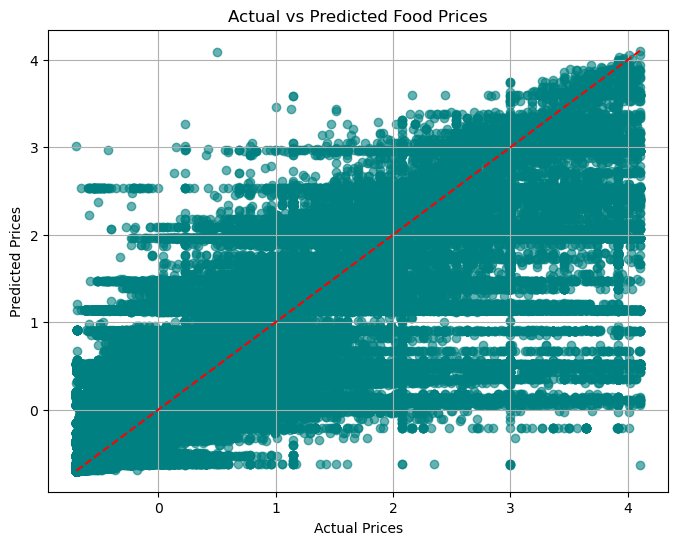

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Food Prices")
plt.grid(True)
plt.show()


In [28]:
import pandas as pd
import numpy as np

# Get selected feature indices
selected_indices = selector.get_support(indices=True)

# Create a mapping of original feature names to selected ones
selected_feature_names = X_train.columns[selected_indices]

# Get feature importances
importances = rf.feature_importances_

# Sort and plot
feat_importance_df = pd.DataFrame({
    'Feature': selected_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_importance_df.head(10))  # Top 10 important features


            Feature  Importance
4          currency    0.432304
0           country    0.220446
3         commodity    0.127370
6              unit    0.078687
1            region    0.077064
8              year    0.052450
5        price_type    0.010603
2            market    0.000550
7             month    0.000527
9  commodity_source    0.000000
